In [1]:
! pip install -q kaggle
from google.colab import files
files.upload()
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle (1).json
mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [2]:
from google.colab import files
files.upload()

Saving count_colors.txt to count_colors (1).txt


{'count_colors.txt': b'0.0024193874813757, 0.3871593847271174, 0.03272240899272358, 0.18459427862628064, 0.07275418318799627, 0.024021267712778408, 0.007342901075145393, 0.006501435963073246, 0.071088467078033, 0.07442635678869804, 0.02695574667969805, 0.0056416929432470874, 0.0002914926265214534, 0.009737487220410432, 0.0005435941199539963, 0.010817066259182736, 0.00011945258905903959, 0.008996880289076145, 0.0018377913141553682, 0.021172934046064476, 0.012597698450075622, 0.0023059791739813464, 0.035952112655352544'}

In [3]:
my_file = open("count_colors.txt", "r")
count_colors = my_file.read()
count_colors = count_colors.split(", ")
for i in range(23):
    count_colors[i] = float(count_colors[i])

print(count_colors)

[0.0024193874813757, 0.3871593847271174, 0.03272240899272358, 0.18459427862628064, 0.07275418318799627, 0.024021267712778408, 0.007342901075145393, 0.006501435963073246, 0.071088467078033, 0.07442635678869804, 0.02695574667969805, 0.0056416929432470874, 0.0002914926265214534, 0.009737487220410432, 0.0005435941199539963, 0.010817066259182736, 0.00011945258905903959, 0.008996880289076145, 0.0018377913141553682, 0.021172934046064476, 0.012597698450075622, 0.0023059791739813464, 0.035952112655352544]


In [4]:
!kaggle datasets download bulentsiyah/semantic-drone-dataset -p /content/sample_data/ --unzip

100% 3.89G/3.89G [02:53<00:00, 25.7MB/s]
100% 3.89G/3.89G [02:53<00:00, 24.1MB/s]


In [5]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms as T
import torchvision
import torch.nn.functional as F
from torch.autograd import Variable

from PIL import Image
import cv2
import albumentations as A

import time
import os
from tqdm.notebook import tqdm

# !pip install -q torchsummary

from torchsummary import summary
import statistics 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [6]:
IMAGE_PATH = '../content/sample_data/dataset/semantic_drone_dataset/original_images/'
MASK_PATH = '../content/sample_data/dataset/semantic_drone_dataset/label_images_semantic/'

In [7]:
n_classes = 23 

def create_df():
    name = []
    for dirname, _, filenames in os.walk(IMAGE_PATH):
        for filename in filenames:
            name.append(filename.split('.')[0])
    
    return pd.DataFrame({'id': name}, index = np.arange(0, len(name)))

df = create_df()
print('Total Images: ', len(df))

Total Images:  400


In [8]:
X_trainval, X_test = train_test_split(df['id'].values, test_size=0.1, random_state=19)
X_train, X_val = train_test_split(X_trainval, test_size=0.15, random_state=19)

print('Train Size   : ', len(X_train))
print('Val Size     : ', len(X_val))
print('Test Size    : ', len(X_test))

Train Size   :  306
Val Size     :  54
Test Size    :  40


Image Size (4000, 6000, 3)
Mask Size (4000, 6000)


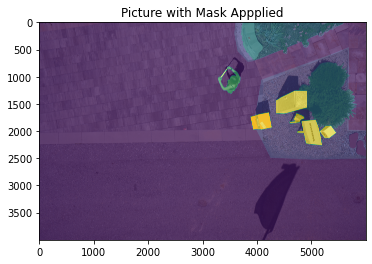

In [9]:
img = Image.open(IMAGE_PATH + df['id'][100] + '.jpg')
mask = Image.open(MASK_PATH + df['id'][100] + '.png')
print('Image Size', np.asarray(img).shape)
print('Mask Size', np.asarray(mask).shape)


plt.imshow(img)
plt.imshow(mask, alpha=0.6)
plt.title('Picture with Mask Appplied')
plt.show()

In [10]:
class DroneDataset(Dataset):

  def __init__(self, img_path, mask_path, X, mean, std, transform=None, patch=False):
    self.img_path = img_path
    self.mask_path = mask_path
    self.X = X
    self.transform = transform
    self.patches = patch
    self.mean = mean
    self.std = std
  
  def __len__(self):
    return len(self.X)

  def __getitem__(self, idx):
        img = cv2.imread(self.img_path + self.X[idx] + '.jpg')
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.mask_path + self.X[idx] + '.png', cv2.IMREAD_GRAYSCALE)
        
        if self.transform is not None:
            aug = self.transform(image=img, mask=mask)
            img = Image.fromarray(aug['image'])
            mask = aug['mask']
        
        if self.transform is None:
            img = Image.fromarray(img)
        
        t = T.Compose([T.ToTensor(), T.Normalize(self.mean, self.std)])
        img = t(img)
        mask = torch.from_numpy(mask).long()
        
        return img, mask

In [11]:
mean=[0.485, 0.456, 0.406]
std=[0.229, 0.224, 0.225]

t_train = A.Compose([A.Resize(704, 1056, interpolation=cv2.INTER_NEAREST), A.HorizontalFlip(), A.VerticalFlip(), 
                     A.GridDistortion(p=0.2), A.RandomBrightnessContrast((0,0.5),(0,0.5)),
                     A.GaussNoise()])

t_val = A.Compose([A.Resize(704, 1056, interpolation=cv2.INTER_NEAREST), A.HorizontalFlip(),
                   A.GridDistortion(p=0.2)])

#datasets
train_set = DroneDataset(IMAGE_PATH, MASK_PATH, X_train, mean, std, t_train, patch=False)
val_set = DroneDataset(IMAGE_PATH, MASK_PATH, X_val, mean, std, t_val, patch=False)

#dataloader
batch_size= 3

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=True)               

In [12]:
# import numpy

# t_find = A.Resize(704, 1056, interpolation=cv2.INTER_NEAREST)
# find_set = DroneDataset(IMAGE_PATH, MASK_PATH, X_train, mean, std, t_find, patch=False)

# count_colors = [0] 
# count_colors *= 23

# for i in range(306):
#     # print(count_colors)
#     _ , mask = find_set[i]
#     np_mask = mask.numpy()

#     unique, counts = numpy.unique(np_mask, return_counts=True)
#     for j, i in enumerate(unique):
#         count_colors[i] += counts[j]

# print(count_colors)

In [13]:
# x = sum(count_colors)
# for i in range(23):
#     count_colors[i] /= x

# print(count_colors)

In [14]:
list_of_colors = []

In [15]:
# for j, i in enumerate(count_colors):
#     if i/sum(count_colors) < 0.005:
#         list_of_colors.append(j)
#         print(j)
#     # print(i)
#     # print(i/sum(count_colors))

In [16]:
# list_of_colors = [0, 12, 14, 16, 18, 21]
# weights = []
# for i in range(23):
#     if (i in list_of_colors):
#         weights.append(5.0)
#     else:
#         weights.append(1.0)
#     # for j in list_of_colors:
#     #     if i == j:
#     #         weights.append(5.0)
#     #         continue
#     # weights.append(1.0)

# class_weights = torch.FloatTensor(weights).cuda()

In [17]:
# print(weights)

In [18]:
from torch import nn
class UNET(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()

        self.down1 = self.down_block(in_channels, 64, 7, 3)
        self.down2 = self.down_block(64, 128, 3, 1)
        self.down3 = self.down_block(128, 256,  3, 1)
        self.down4 = self.down_block(256, 512,  3, 1)
        self.down5 = self.down_block(512, 1024, 3, 1)

        self.last = self.down_block(128, 64, 3, 1)
        self.last1 = torch.nn.Conv2d(64, out_channels, kernel_size=1)
        self.pool = torch.nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        

        self.upconv5 = self.expand_block(1024, 512, 3, 1)
        # self.upconv4 = self.expand_block(512 * 2, 256, 3, 1)
        self.upconv4 = self.expand_block(512, 256, 3, 1)

        self.upconv3 = self.expand_block(256 * 2, 128, 3, 1)
        # self.upconv3 = self.expand_block(256, 128, 3, 1)

        self.upconv2 = self.expand_block(128 * 2, 64, 3, 1)

      
    def down_block(self, in_channels, out_channels, kernel_size, padding):
        down = nn.Sequential(
            torch.nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=1, padding=padding),
            torch.nn.BatchNorm2d(out_channels),
            torch.nn.ReLU(),
            torch.nn.Conv2d(out_channels, out_channels, kernel_size=kernel_size, stride=1, padding=padding),
            torch.nn.BatchNorm2d(out_channels),
            torch.nn.ReLU()
        )
        return down

    def expand_block(self, in_channels, out_channels, kernel_size, padding):
        expand = nn.Sequential(torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=padding),
                            torch.nn.BatchNorm2d(out_channels),
                            torch.nn.ReLU(),
                            torch.nn.Conv2d(out_channels, out_channels, kernel_size, stride=1, padding=padding),
                            torch.nn.BatchNorm2d(out_channels),
                            torch.nn.ReLU(),
                            torch.nn.ConvTranspose2d(out_channels, out_channels, kernel_size=3, stride=2, padding=1, output_padding=1) 
                            )
        return expand

    def forward(self, x):
        # downsampling part
        conv1 = self.down1(x)
        conv2 = self.down2(self.pool(conv1))
        conv3 = self.down3(self.pool(conv2))
        conv4 = self.down4(self.pool(conv3))
        # conv5 = self.down5(self.pool(conv4))

        # upconv5 = self.upconv5(conv5)
        # upconv4 = self.upconv4(torch.cat([upconv5, conv4], 1))
        upconv4 = self.upconv4(conv4)
        upconv3 = self.upconv3(torch.cat([upconv4, conv3], 1))
        upconv2 = self.upconv2(torch.cat([upconv3, conv2], 1))
        upconv1 = self.last1(self.last(torch.cat([upconv2, conv1], 1)))
        return upconv1 

In [19]:
# model = UNET(3, 23)
# optimizer = torch.optim.Adam(model.parameters())

# epochs = 15

In [20]:
# print(error)

In [21]:
import torch
torch.cuda.empty_cache()
print(torch.cuda.memory_allocated()/1024/1024)

0.0


In [22]:
# checkpoint = torch.load('dice_7ep.pt')
# model.load_state_dict(checkpoint['model_state_dict'])
# optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
# epoch = checkpoint['epoch']
# loss = checkpoint['loss']

# model = model.cuda()

In [23]:
# weights = []
# for i in class_accuracy:
#     if (i < 0.05):
#         weights.append(5.0)
#     elif (i > 0.5):
#         weights.append(0.7)
#     else:
#         weights.append(1.0)
# print(weights)
# class_weights = torch.FloatTensor(weights).cuda()

In [24]:
# len(weights)

In [25]:
# criterion = nn.CrossEntropyLoss(weight=class_weights)

In [26]:
# print(output.shape)
# print(y.shape)

In [27]:
# model.cuda()

In [28]:
class FocalLoss(nn.Module):
    def __init__(self, gamma=0, alpha=None, size_average=True):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        # self.alpha = alpha
        # if isinstance(alpha,(float, int, long)): self.alpha = torch.Tensor([alpha,1-alpha])
        # if isinstance(alpha, list): self.alpha = torch.Tensor(alpha)
        self.size_average = size_average

    def forward(self, input, target):
        input = input.view(input.size(0), input.size(1), -1)  # N,C,H,W => N,C,H*W
        input = input.transpose(1, 2)    # N,C,H*W => N,H*W,C
        input = input.contiguous().view(-1, input.size(2))   # N,H*W,C => N*H*W,C
        target = target.view(-1, 1)

        logpt = F.log_softmax(input, -1)
        logpt = logpt.gather(1, target)
        logpt = logpt.view(-1)
        pt = logpt.data.exp()
        pt.requiers_grad = True
        # if self.alpha is not None:
        #     if self.alpha.type() != input.data.type():
        #         self.alpha = self.alpha.type_as(input.data)
        #     at = self.alpha.gather(0,target.data.view(-1))
        #     logpt = logpt * Variable(at)

        loss = -1 * (1 - pt) ** self.gamma * logpt
        if self.size_average: 
            return loss.mean()
        else: 
            return loss.sum()

In [29]:
# criterion = FocalLoss(gamma = 2)

In [30]:
# class TverskyLoss(nn.Module):
#     def __init__(self, alpha=0.5, beta=0.5, eps=1e-7):
#         super(TverskyLoss, self).__init__()
#         self.alpha = alpha
#         self.beta = beta
#         self.eps = eps

#     def forward(self, true, logits):
#         true = true.long()
#         true = logits.long()
#         num_classes = logits.shape[1]
#         true_1_hot = torch.eye(num_classes)[true.squeeze(1)]
#         true_1_hot = true_1_hot.permute(0, 3, 1, 2).float()
#         probas = F.softmax(logits, dim=1)

#         true_1_hot = true_1_hot.type(logits.type())
#         dims = (0,) + tuple(range(2, true.ndimension()))
#         intersection = torch.sum(probas * true_1_hot, dims)
#         fps = torch.sum(probas * (1 - true_1_hot), dims)
#         fns = torch.sum((1 - probas) * true_1_hot, dims)
#         num = intersection
#         denom = intersection + (self.alpha * fps) + (self.beta * fns)
#         tversky_loss = (num / (denom + self.eps)).mean()

#         return (1 - tversky_loss)

In [31]:
# criterion = TverskyLoss()

In [32]:
smooth = 1

all_colors = [0] * 24
correct_colors = [0] * 24
guessed_colors = [0] * 24
loss = []


class DiceLoss(nn.Module):
    def __init__(self):
        super(DiceLoss, self).__init__()
        
    def forward(self, output, y):
        smooth = 1
        all_colors = [0] * 24
        correct_colors = [0] * 24
        guessed_colors = [0] * 24
        loss = []

        output = torch.argmax(F.softmax(output, dim=1), dim=1)
        output += 1
        y += 1
        correct = torch.eq(output, y).int()
        correct = correct.cuda()

        # incorrect = torch.ne(output, y).int()
        # incorrect = correct.cuda()

        output = output.cpu()
        np_output = output.numpy()
        unique_output, counts_output = np.unique(np_output, return_counts=True)
        output = output.cuda()

        output = output * correct
        y = y.cpu()
        np_y = y.numpy()
        unique_y, counts_y = np.unique(np_y, return_counts=True)
            
        for j, i in enumerate(unique_y):
            guessed_colors[i] += counts_y[j]

        output = output.cpu()
        np_output = output.numpy()
        unique_output, counts_output = np.unique(np_output, return_counts=True)

        for j, i in enumerate(unique_y):
            all_colors[i] += counts_y[j]

        for j, i in enumerate(unique_output):
            correct_colors[i] += counts_output[j]

        for i in range(23):
            if (count_colors[i] > 0.04):
                if (count_colors[i] > 0.1):
                    loss.append(2 * correct_colors[i] * 0.01 / (all_colors[i] + guessed_colors[i] + smooth))
                else:
                    loss.append(2 * correct_colors[i] * 0.1 / (all_colors[i] + guessed_colors[i] + smooth))
            else:
                loss.append(2 * correct_colors[i] / (all_colors[i] + guessed_colors[i] + smooth))

        return statistics.mean(loss)
    # for j, i in enumerate(unique_output):
    #     incorrect_colors[i] += counts_output[j]

In [42]:
def dice_loss(true, logits, eps=1e-7):
    num_classes = logits.shape[1]
    
    # true_1_hot = torch.eye(num_classes)[true.squeeze(1)]
    true_1_hot = torch.eye(num_classes)
    # print(true_1_hot)
    true_1_hot = true_1_hot.cuda()
    true_1_hot = true_1_hot[true.squeeze(1)]
    # print(true_1_hot.shape)

    true_1_hot = true_1_hot.permute(0, 3, 1, 2).float()
    # print(true_1_hot.shape)
    probas = F.softmax(logits, dim=1)

    true_1_hot = true_1_hot.type(logits.type())
    dims = (0,) + tuple(range(2, true.ndimension()))
    intersection = torch.sum(probas * true_1_hot, dims)
    cardinality = torch.sum(probas + true_1_hot, dims)
    # print(intersection)
    # print(cardinality)

    dice_loss = (2. * intersection / (cardinality + eps)).mean()

    return (1 - dice_loss)

In [34]:
weights = torch.eye(23)
lst = []
for i in range(23):
    if count_colors[i] > 0.04:
        if count_colors[i] > 0.1:
            weights[i][i] = 0.1
            lst.append(0.1)
        else:
            weights[i][i] = 0.5
            lst.append(0.5)

    else:
        weights[i][i] = 1.0
        lst.append(1.0)

x = statistics.mean(lst)
for i in range(23):
    weights[i][i] /= x

In [35]:
weight = []
for i in range(23):
    if count_colors[i] > 0.04:
        if count_colors[i] > 0.1:
            weight.append(0.05)
        else:
            weight.append(0.5)
    else:
        weight.append(1.0)

x = statistics.mean(weight)

for i in range(23):
    weight[i] = weight[i] / x

In [36]:
# for x, y in val_loader:
#     x = x.cuda()
#     y = y.cuda()
#     model.cuda()

#     with torch.no_grad():
#         output = model(x)
#         print(eddynet_dice(y.long(), output))
#         break

In [37]:
print(count_colors)

[0.0024193874813757, 0.3871593847271174, 0.03272240899272358, 0.18459427862628064, 0.07275418318799627, 0.024021267712778408, 0.007342901075145393, 0.006501435963073246, 0.071088467078033, 0.07442635678869804, 0.02695574667969805, 0.0056416929432470874, 0.0002914926265214534, 0.009737487220410432, 0.0005435941199539963, 0.010817066259182736, 0.00011945258905903959, 0.008996880289076145, 0.0018377913141553682, 0.021172934046064476, 0.012597698450075622, 0.0023059791739813464, 0.035952112655352544]


In [38]:
import time
def train(model, train_dl, valid_dl, loss_fn, optimizer, acc_fn, epochs=1):
    start = time.time()
    model.cuda()
    train_loss, valid_loss = [], []
    best_acc = 0.0

    for epoch in range(epochs):
        print('Epoch {}/{}'.format(epoch, epochs - 1))
        print('-' * 10)
        for phase in ['train', 'valid']:
            if phase == 'train':
                model.train(True)  # Set trainind mode = true
                dataloader = train_dl
            else:
                model.train(False)  # Set model to evaluate mode
                dataloader = valid_dl
            running_loss = 0.0
            running_acc = 0.0
            step = 0
            for x, y in dataloader:
                x = x.cuda()
                y = y.cuda()
                step += 1

                if phase == 'train':
                    optimizer.zero_grad()
                    outputs = model(x)
                    # loss = loss_fn(outputs, y)
                    loss = dice_loss(y.long(), outputs)

                    loss.backward()
                    optimizer.step()

                else:
                    with torch.no_grad():
                        outputs = model(x)
                        # loss = loss_fn(outputs, y.long())

                        loss = dice_loss(y.long(), outputs)
                acc = acc_fn(outputs, y)

                running_acc  += acc*dataloader.batch_size
                running_loss += loss*dataloader.batch_size 
                if step % 10 == 0:
                    print('Current step: {}  Loss: {}  Acc: {}   AllocMem (Mb): {}'.format(step, loss, acc, torch.cuda.memory_allocated()/1024/1024))

            epoch_loss = running_loss / len(dataloader.dataset)
            epoch_acc = running_acc / len(dataloader.dataset)

            print('{} Loss: {:.4f} Acc: {}'.format(phase, epoch_loss, epoch_acc))

            train_loss.append(epoch_loss) if phase=='train' else valid_loss.append(epoch_loss)
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss,
            }, 'model.pt')
    time_elapsed = time.time() - start
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))    
    
    return train_loss, valid_loss    

def pixel_accuracy(output, mask):
    with torch.no_grad():
        output = torch.argmax(F.softmax(output, dim=1), dim=1)
        correct = torch.eq(output, mask).int()
        accuracy = float(correct.sum()) / float(correct.numel())
    return accuracy

In [39]:
# criterion = DiceLoss()

In [40]:
!pip install -q segmentation-models-pytorch
import segmentation_models_pytorch as smp

model = smp.Unet('mobilenet_v2', encoder_weights='imagenet', classes=23, activation=None, encoder_depth=5, decoder_channels=[256, 128, 64, 32, 16])
optimizer = torch.optim.Adam(model.parameters())
# criterion = FocalLoss(gamma = 2)
criterion = DiceLoss()

# sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epoch,
                                            # steps_per_epoch=len(train_loader))
# criterion = nn.CrossEntropyLoss()

In [43]:
train_loss, valid_loss = train(model, train_loader, val_loader, criterion, optimizer, pixel_accuracy, epochs=50)
# fit()

Epoch 0/49
----------
Current step: 10  Loss: 0.967720091342926  Acc: 0.32355111842860423   AllocMem (Mb): 5566.0224609375
Current step: 20  Loss: 0.9378688931465149  Acc: 0.46229338842975204   AllocMem (Mb): 5566.0224609375
Current step: 30  Loss: 0.929384708404541  Acc: 0.5699587314910468   AllocMem (Mb): 5566.0224609375
Current step: 40  Loss: 0.9151525497436523  Acc: 0.5972661630509641   AllocMem (Mb): 5566.0224609375
Current step: 50  Loss: 0.9179059267044067  Acc: 0.42437962723829203   AllocMem (Mb): 5566.0224609375
Current step: 60  Loss: 0.9069490432739258  Acc: 0.537361362201561   AllocMem (Mb): 5566.0224609375
Current step: 70  Loss: 0.9442574977874756  Acc: 0.3662696747302571   AllocMem (Mb): 5566.0224609375
Current step: 80  Loss: 0.9455357789993286  Acc: 0.3494183669077135   AllocMem (Mb): 5566.0224609375
Current step: 90  Loss: 0.8968102335929871  Acc: 0.47615806502525254   AllocMem (Mb): 5566.0224609375
Current step: 100  Loss: 0.902990460395813  Acc: 0.5346365824437558 

KeyboardInterrupt: ignored

In [44]:
all_colors = [0] * 24
correct_colors = [0] * 24

for x, y in val_loader:
    x = x.cuda()
    y = y.cuda()
    model.cuda()

    with torch.no_grad():
        output = model(x)
        output = torch.argmax(F.softmax(output, dim=1), dim=1)
        output += 1
        y += 1
        correct = torch.eq(output, y).int()
        correct = correct.cuda()
        output = output * correct
        y = y.cpu()
        np_y = y.numpy()
        unique_y, counts_y = np.unique(np_y, return_counts=True)
        
        output = output.cpu()
        np_output = output.numpy()
        unique_output, counts_output = np.unique(np_output, return_counts=True)

        for j, i in enumerate(unique_y):
            all_colors[i] += counts_y[j]

        for j, i in enumerate(unique_output):
            correct_colors[i] += counts_output[j]


print(all_colors[1:24])
print(correct_colors[1:24])

class_accuracy = []
for i in range(1, 24):
    class_accuracy.append(correct_colors[i] / all_colors[i])

with open("dice_10ep.txt", "w") as output:
    output.write(str(class_accuracy))

print(class_accuracy)

[95943, 15209742, 1121144, 9203012, 2523661, 279707, 113123, 222383, 2883123, 3516661, 981064, 262218, 16632, 233888, 9397, 361293, 3492, 477293, 48145, 522859, 644994, 37842, 1377280]
[40382, 13029513, 720469, 8565319, 1994006, 207534, 56350, 0, 1806621, 2537487, 401234, 42709, 0, 87036, 0, 286540, 0, 0, 23003, 239660, 244385, 0, 562490]
[0.42089574017906467, 0.856655753924031, 0.6426195029362866, 0.9307082290015486, 0.790124347129032, 0.7419692749913303, 0.49813035368581104, 0.0, 0.6266194678478858, 0.7215614470658389, 0.4089784152715827, 0.16287592766324205, 0.0, 0.37212682993569574, 0.0, 0.7930959083071081, 0.0, 0.0, 0.47778585522899575, 0.4583644921479787, 0.3788949974728447, 0.0, 0.4084064242565056]


In [45]:
class DroneTestDataset(Dataset):
    
    def __init__(self, img_path, mask_path, X, transform=None):
        self.img_path = img_path
        self.mask_path = mask_path
        self.X = X
        self.transform = transform
      
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        img = cv2.imread(self.img_path + self.X[idx] + '.jpg')
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.mask_path + self.X[idx] + '.png', cv2.IMREAD_GRAYSCALE)
        
        if self.transform is not None:
            aug = self.transform(image=img, mask=mask)
            img = Image.fromarray(aug['image'])
            mask = aug['mask']
        
        if self.transform is None:
            img = Image.fromarray(img)
        
        mask = torch.from_numpy(mask).long()
        
        return img, mask


t_test = A.Resize(768, 1152, interpolation=cv2.INTER_NEAREST)
test_set = DroneTestDataset(IMAGE_PATH, MASK_PATH, X_test, transform=t_test)

In [46]:
def predict_image_mask_pixel(model, image, mask, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    model.eval()
    t = T.Compose([T.ToTensor(), T.Normalize(mean, std)])
    image = t(image)
    model.to(device); image=image.to(device)
    mask = mask.to(device)
    with torch.no_grad():
        
        image = image.unsqueeze(0)
        mask = mask.unsqueeze(0)
        
        output = model(image)
        masked = torch.argmax(output, dim=1)
        masked = masked.cpu().squeeze(0)
    return masked

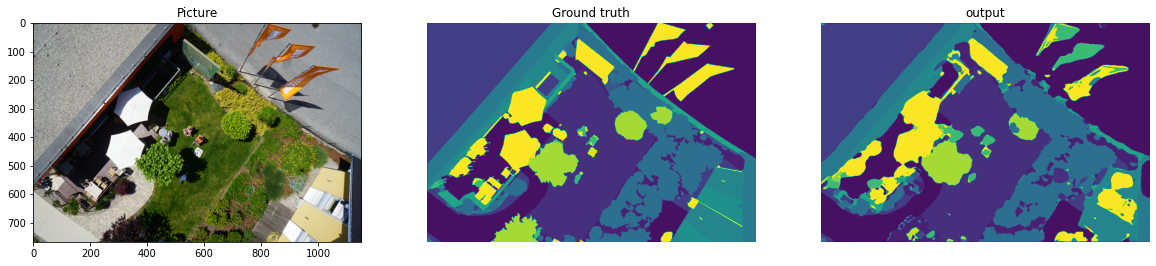

In [47]:
image, mask = test_set[0]
output = predict_image_mask_pixel(model, image, mask, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(20,10))
ax1.imshow(image)
ax1.set_title('Picture');

ax2.imshow(mask)
ax2.set_title('Ground truth')
ax2.set_axis_off()

ax3.imshow(output)
ax3.set_title('output')
ax3.set_axis_off()

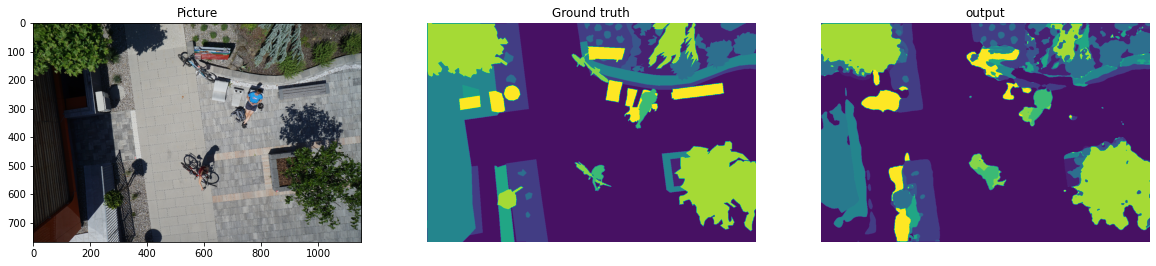

In [50]:
image, mask = test_set[1]
output = predict_image_mask_pixel(model, image, mask, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(20,10))
ax1.imshow(image)
ax1.set_title('Picture');

ax2.imshow(mask)
ax2.set_title('Ground truth')
ax2.set_axis_off()

ax3.imshow(output)
ax3.set_title('output')
ax3.set_axis_off()

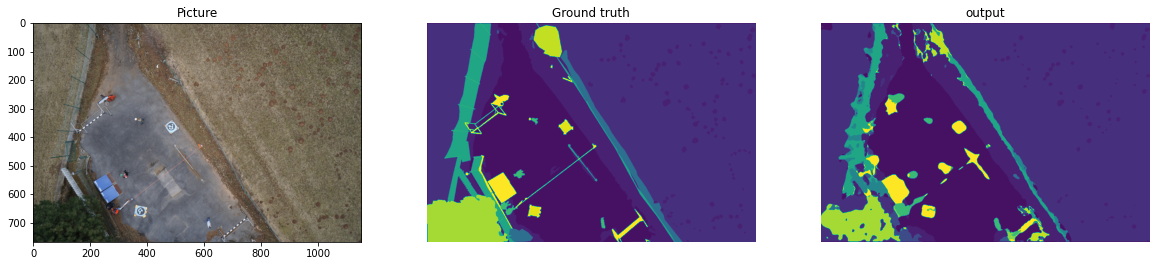

In [51]:
image, mask = test_set[2]
output = predict_image_mask_pixel(model, image, mask, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(20,10))
ax1.imshow(image)
ax1.set_title('Picture');

ax2.imshow(mask)
ax2.set_title('Ground truth')
ax2.set_axis_off()

ax3.imshow(output)
ax3.set_title('output')
ax3.set_axis_off()